# Filtering images
Image filters take an image and produce a new image. Typically, a filter kernel goes from pixel to pixel and computes a new pixel value depending on an old pixel and its neighborhood.

See also
* [Filters in scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html)

We start with a test image and apply a Gaussian blur filter.

In [38]:
import numpy as np
test_image = np.zeros((10,10))
test_image[5,3] = 1
test_image[5,7] = 1
test_image

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

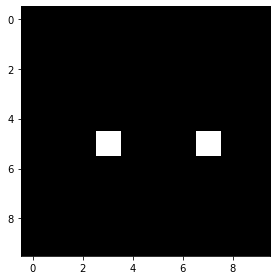

In [39]:
from skimage.io import imshow
imshow(test_image)

The [Gaussian filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) takes two important arguments, the image to blur and a sigma parameter. The sigma determines how wide the Gaussian blur should show effects.

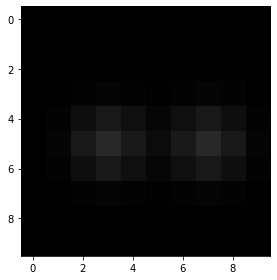

In [40]:
from skimage.filters import gaussian

blurred = gaussian(test_image, sigma=1)
imshow(blurred)

Let's compare Gaussian blurred images with different sigma

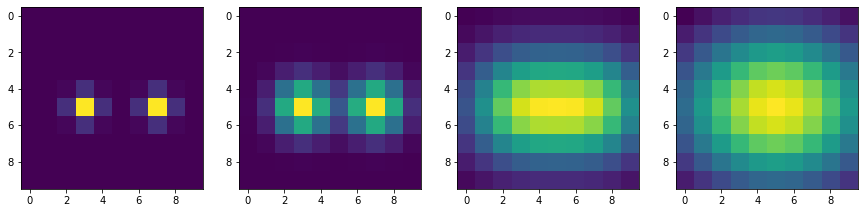

In [41]:
blurred05 = gaussian(test_image, sigma=0.5)
blurred1 = gaussian(test_image, sigma=1)
blurred2 = gaussian(test_image, sigma=2)
blurred3 = gaussian(test_image, sigma=3)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(blurred05)
axs[1].imshow(blurred1)
axs[2].imshow(blurred2)
axs[3].imshow(blurred3)

Note: If the sigma is larger than the distance between two spots, the spots cannot be differentiated as two local maxima in the blurred image anymore. 

#### Filters with structuring elements
Some filters ask for a structuring element as [parameter](https://scikit-image.org/docs/dev/auto_examples/numpy_operations/plot_structuring_elements.html#sphx-glr-auto-examples-numpy-operations-plot-structuring-elements-py).
In biological/microscopy applications, the [disk](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.disk) sturcturing element is most commonly used.
To understand it, we should visualize it first. A disk with radius 4 is a 9x9 large image containing black pixels(intensity=0) and disk-shaped pixels with value 1.

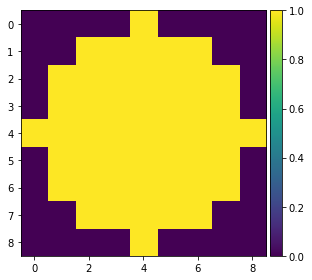

In [42]:
from skimage.morphology import disk

imshow(disk(4))

Disks with other radii look like this:

1
2
3
4
5


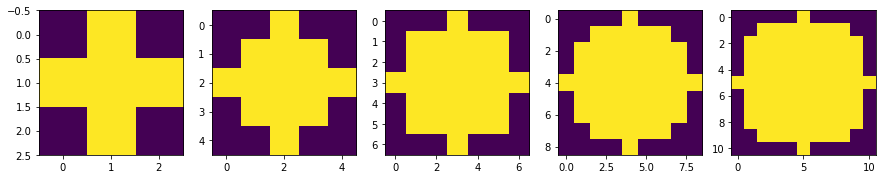

In [43]:
max_radius = 5

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, max_radius, figsize=(15,15))

for r in range(1, max_radius + 1):
    print(r)
    axs[r - 1].imshow(disk(r))

Coming back to our test image, this is how it looks like when we apply a mean filter with different disk radii.

Text(0.5, 1.0, 'Mean (radius = 3)')

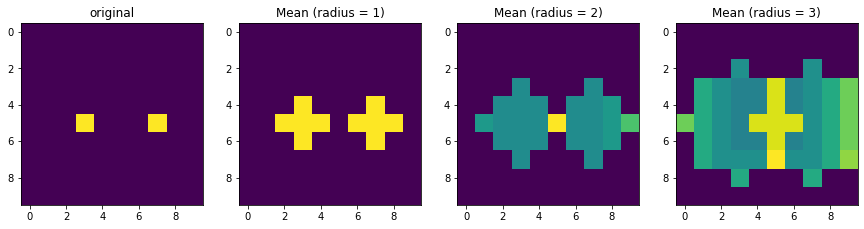

In [47]:
from skimage import filters 

filtered1 = filters.rank.mean(test_image, disk(1))
filtered2 = filters.rank.mean(test_image, disk(2))
filtered3 = filters.rank.mean(test_image, disk(3))

fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(test_image)
axs[0].set_title('original')

axs[1].imshow(filtered1)
axs[1].set_title('Mean (radius = 1)')

axs[2].imshow(filtered2)
axs[2].set_title('Mean (radius = 2)')

axs[3].imshow(filtered3)
axs[3].set_title('Mean (radius = 3)')


## Noise removal filters
Filter such as `mean`, `median` and `Gaussian` allow removing noise from images.

We start with a single plane of the MRT example data set which is pretty noisy and zoom in.

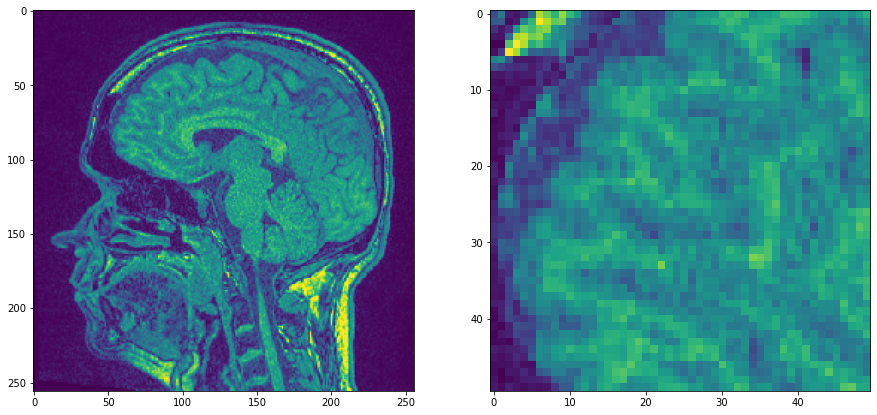

In [61]:
from skimage.io import imread

# open dataset and extract single plane
noisy_mri = imread('../data/Haase_MRT_tfl3d1.tif')[92]

# zoom in by cropping a part out
noisy_mri_zoom = noisy_mri[50:100, 50:100]

fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].imshow(noisy_mri)
axs[1].imshow(noisy_mri_zoom)

Now we apply three filters and compare resulting images.

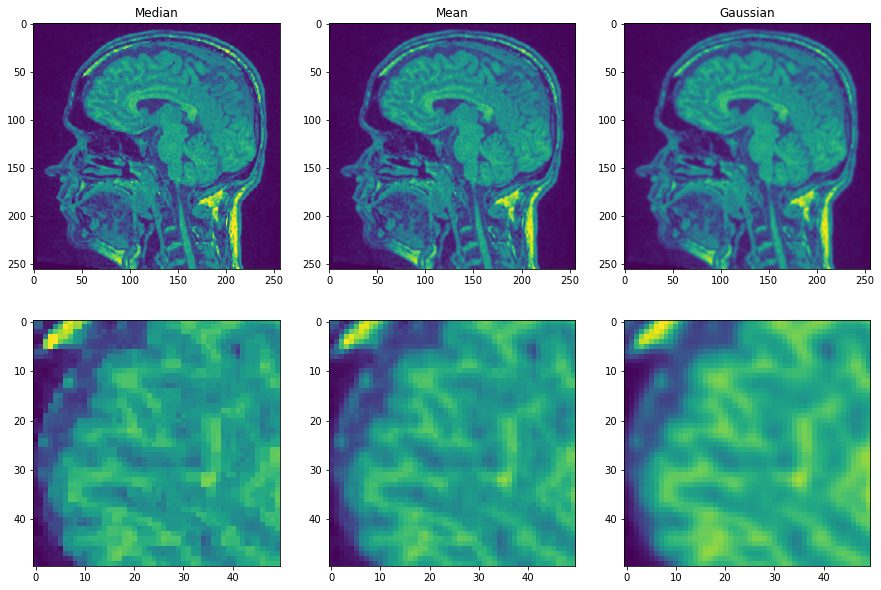

In [68]:
median_filtered = filters.median(noisy_mri, disk(1))
mean_filtered = filters.rank.mean(noisy_mri, disk(1))
gaussian_filtered = filters.gaussian(noisy_mri, sigma=1)

fig, axs = plt.subplots(2, 3, figsize=(15,10))

# first row
axs[0, 0].imshow(median_filtered)
axs[0, 0].set_title("Median")
axs[0, 1].imshow(mean_filtered)
axs[0, 1].set_title("Mean")
axs[0, 2].imshow(gaussian_filtered)
axs[0, 2].set_title("Gaussian")

# second row
axs[1, 0].imshow(median_filtered[50:100, 50:100])
axs[1, 1].imshow(mean_filtered[50:100, 50:100])
axs[1, 2].imshow(gaussian_filtered[50:100, 50:100])


You may agree, that the first image shows edges more prominently than the other two. This is because the [median filter is edge preserving](https://en.wikipedia.org/wiki/Median_filter).

## Background removing filters
There are also background removal filters. If there is a more or less homogeneous intensity spread over the whole image, potentially increasing in a direction, it is recommended to remove this background before segmenting the image.

As example image, we will work with a zebrafish eye data set (Courtesy, Mauricio Rocha Martins, Norden lab, MPI CBG). As you can see, there is some intensity spread around the nuclei we want to segment later on. The source of this background signal is out-of-focus light.

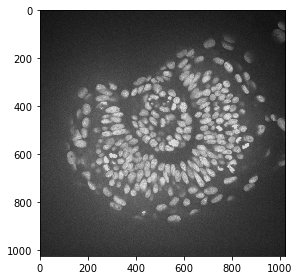

In [71]:
from skimage.io import imread, imshow

# load zfish image and extract a channel
zfish_image = imread('../data/zfish_eye.tif')[:,:,0]

imshow(zfish_image)

To subtract the background, we need to determine it first. We can use the [rolling-ball algorithm](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rolling_ball.html) for that. The radius parameter configures how distant pixels should be taken into account for determining the background intensity.

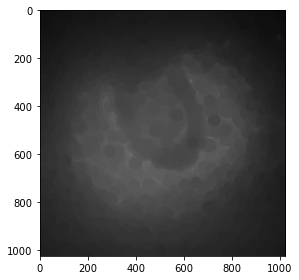

In [76]:
from skimage import restoration

background_rolling = restoration.rolling_ball(zfish_image, radius=25)

imshow(background_rolling)

Afterwards, we subtract the background from the original and display all three images:

Text(0.5, 1.0, 'Background subtracted')

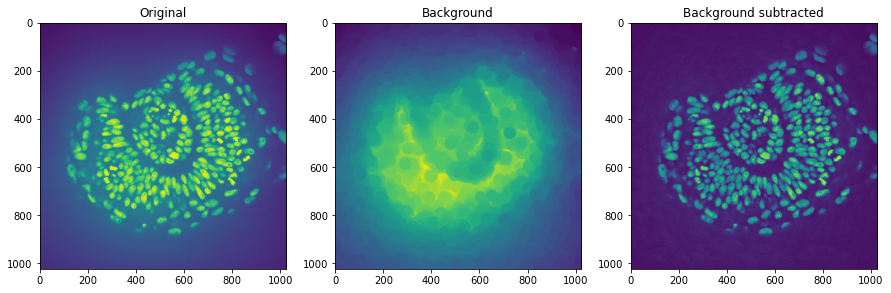

In [78]:
zfish_rolling = zfish_image - background_rolling

fig, axs = plt.subplots(1, 3, figsize=(15,10))

# first row
axs[0].imshow(zfish_image)
axs[0].set_title("Original")
axs[1].imshow(background_rolling)
axs[1].set_title("Background")
axs[2].imshow(zfish_rolling)
axs[2].set_title("Background subtracted")

There are other techniques such as the [Difference of Gaussians (DoG)](https://scikit-image.org/docs/stable/auto_examples/filters/plot_dog.html) and the [top-hat](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#white-tophat) for background subtraction. In the following we compare them.

Text(0.5, 1.0, 'Rolling ball algorithm')

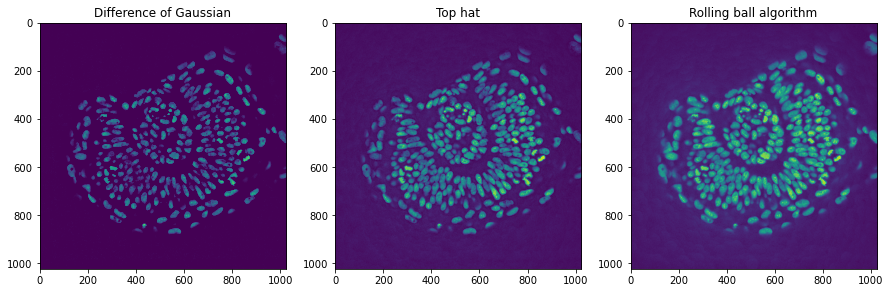

In [81]:
# DoG
from skimage.filters import difference_of_gaussians
zfish_dog = difference_of_gaussians(zfish_image, 0, 15)

# Top-Hat
from skimage.morphology import white_tophat
zfish_top_hat = white_tophat(zfish_image, disk(15))

fig, axs = plt.subplots(1, 3, figsize=(15,10))

# first row
axs[0].imshow(zfish_dog, vmin=0)
axs[0].set_title("Difference of Gaussian")
axs[1].imshow(zfish_top_hat)
axs[1].set_title("Top hat")
axs[2].imshow(zfish_rolling)
axs[2].set_title("Rolling ball algorithm")

## Other filters
Other filters allow extracting edges, determining directions of edges and a lot more. Here just three examples.

<ipython-input-84-5484c9a8c0f2>:9: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  zfish_hessian = filters.hessian(zfish_image)


Text(0.5, 1.0, 'Hessian')

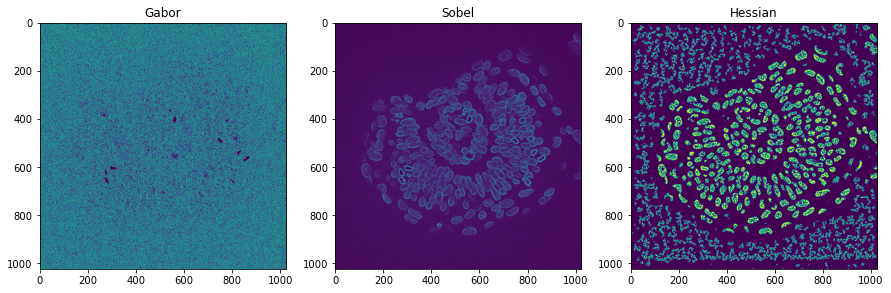

In [84]:
# Gabor filter
from skimage import filters
zfish_gabor = filters.gabor(zfish_image, frequency=0.5)[0]

# Sobel filter
zfish_sobel = filters.sobel(zfish_image)

# Hessian filter
zfish_hessian = filters.hessian(zfish_image)

fig, axs = plt.subplots(1, 3, figsize=(15,10))

# first row
axs[0].imshow(zfish_gabor)
axs[0].set_title("Gabor")
axs[1].imshow(zfish_sobel)
axs[1].set_title("Sobel")
axs[2].imshow(zfish_hessian)
axs[2].set_title("Hessian")

## Exercise
Apply different algorithms and radii to remove the background in the zebrafish eye dataset. Zoom into the dataset using cropping and figure out how to make the background go away optimally.